In [187]:
import os
import sys
import glob
import math
import pandas as pd
import subprocess
from multiprocessing import Pool
import multiprocessing 


import umap
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from biopandas.pdb import PandasPdb

sys.path.append('../../hamp_pred/')
from utils.tools import diffangle


data_dir = '../../data/input'

In [367]:
hamp_groups_df = pd.read_csv('../../../TCST/offline_data/hamp/groupnames.csv', names=['paper_group', 'group'])
hamp_groups_df['group'] = hamp_groups_df['group'].apply(lambda x:x.replace('.fas', ''))
paper2group = dict(hamp_groups_df.values) #my_array
group2paper = dict(hamp_groups_df.values[:, [1, 0]])
data_df = pd.read_pickle(os.path.join(data_dir, 'af2.p'))
data_df.group = data_df.group.apply(lambda x:group2paper[x] if x in group2paper else '?')
len(data_df)

5314

In [368]:
# remove background sequences
#data_df = data_df[data_df.group != '?']

In [369]:
# calculate the relative rotation (i.e., the per-layer difference between N and C helices rotation) 
data_df['rot'] = diffangle(data_df.n_crick_mut, data_df.c_crick_mut)
data_df['rot_mean'] = data_df['rot'].apply(np.mean)
data_df['rot_std'] = data_df['rot'].apply(np.std)
data_df['sequence'] = data_df['n_seq'] + data_df['c_seq'] # for mmseqs2 clustering

len(data_df)

5314

In [370]:
# referece Crick angles
crangles = {'a':19.5,'b':122.35,'c':-134.78,'d': -31.92,'e':70.92 ,'f':173.78,'g':-83.35}

def check_crick(row, MAXROT=55):
    return (np.abs(diffangle(row.n_crick_mut[:2].mean(), crangles['a'])) <= MAXROT) and \
           (np.abs(diffangle(row.c_crick_mut[:2].mean(), crangles['a'])) <= MAXROT) 


data_df = data_df[data_df.apply(check_crick, axis=1)]
len(data_df)

5124

In [371]:
data_df = data_df[data_df.rot_std <= 14]
data_df = data_df[data_df.rot_mean.abs() <= 52]
len(data_df)

4972

# FoldSeek

In [4]:
# get symlinks to all pdb files

pdb_dir = '/home/users/sdunin/calc/HAMPpred/data/input/af2_full'

clust_dir = '/home/users/sdunin/calc/TCST/HAMP_AF2_cluster'
ln_dir = clust_dir + '/pdbs'

f = open(os.path.join(clust_dir, 'chain_list'), 'w')

for i, row in tqdm(data_df.iterrows(), total=len(data_df)):
    os.system(f'ln -sf {os.path.join(pdb_dir,row.pdb_file)} {ln_dir}')
    
    f.write(f'{os.path.basename(row.pdb_file)}\n')
     
f.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5314/5314 [01:30<00:00, 58.55it/s]


In [5]:
# merge chains 
in_pdbs = '/home/users/sdunin/calc/TCST/HAMP_AF2_cluster/pdbs/'

def merge_chains(pdb1, pdb2):

    model = PandasPdb().read_pdb(pdb1)
    model_df = model.df['ATOM']

    # Calculate res_count
    res_count = model_df[model_df.chain_id == 'A']['residue_number'].max()

    # Iterate through rows where chain_id is 'B'
    for res_id, g in model_df[model_df.chain_id == 'B'].groupby('residue_number'):
        model_df.loc[g.index, 'residue_number'] = res_id + res_count

    ca_residue_numbers = model_df[model_df.atom_name == 'CA']['residue_number']
    assert ca_residue_numbers.is_unique and ca_residue_numbers.is_monotonic_increasing

    model_df.chain_id = 'A'
    
    model.to_pdb(path=pdb2, 
            records=None, 
            gz=False, 
            append_newline=True)
    
for in_pdb in tqdm(glob.glob(os.path.join(in_pdbs, '*.pdb'))):
    out_pdb = in_pdb.replace('/pdbs/', '/pdbs_onechain/')
    merge_chains(in_pdb, out_pdb)
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5314/5314 [07:49<00:00, 11.31it/s]


In [95]:
# run foldseek in /home/users/sdunin/calc/TCST/HAMP_AF2_cluster

# Parse results

In [373]:
clu_results = '/home/users/sdunin/calc/TCST/HAMP_AF2_cluster/aln.csv'
res_df = pd.read_csv(clu_results, names=['query','target','lnlen','evalue','alntmscore','prob', 'lddt'], sep='\t')
res_df.head()

,query,target,lnlen,evalue,alntmscore,prob,lddt
0,hamp_3352_relaxed_rank_1_model_3.pdb,hamp_3352_relaxed_rank_1_model_3.pdb,108,1.0000,1.0000,1.000,1.0000
1,hamp_3352_relaxed_rank_1_model_3.pdb,hamp_3393_relaxed_rank_1_model_3.pdb,110,0.8123,0.8522,0.986,0.7303
2,hamp_3352_relaxed_rank_1_model_3.pdb,hamp_1089_relaxed_rank_1_model_3.pdb,110,0.8097,0.8484,0.984,0.7385
3,hamp_3352_relaxed_rank_1_model_3.pdb,hamp_3944_relaxed_rank_1_model_3.pdb,108,0.8084,0.8612,0.981,0.7086
4,hamp_3352_relaxed_rank_1_model_3.pdb,hamp_1314_relaxed_rank_1_model_2.pdb,110,0.8068,0.8472,0.984,0.7273


In [374]:
# remove hits with low coverage
#res_df = res_df[res_df.lnlen >= 100]

In [375]:
# map to data_df indexes
pdb2idx = {v.split('/')[1]:k for k,v in zip(data_df.index, data_df['pdb_file'])}
res_df['i'] = res_df['query'].apply(lambda x:pdb2idx[x] if x in pdb2idx else -1)
res_df['j'] = res_df['target'].apply(lambda x:pdb2idx[x] if x in pdb2idx else -1)

# remove hits that involve structures that are not in data_df
res_df = res_df[(res_df['i'] != -1) & (res_df['j'] != -1)]

In [376]:
# #scale e-value
# res_df['evalue'] = res_df.evalue.apply(lambda x:-math.log10(x))

In [377]:
matrix_df = res_df.pivot(index='i', columns='j', values='alntmscore')

# use 0 for alntmscore
matrix_df = matrix_df.fillna(0)

matrix_array = matrix_df.to_numpy()
assert matrix_array.shape[0] == matrix_array.shape[1] == len(data_df)
matrix_array.shape

(4972, 4972)

In [378]:
matrix_array

array([[1.    , 0.969 , 0.9802, ..., 0.863 , 0.764 , 0.7468],
       [0.969 , 1.    , 0.9802, ..., 0.8734, 0.7796, 0.7326],
       [0.9802, 0.9802, 1.    , ..., 0.8735, 0.7632, 0.7498],
       ...,
       [0.863 , 0.8734, 0.8735, ..., 1.    , 0.8542, 0.7087],
       [0.764 , 0.7796, 0.7632, ..., 0.8542, 1.    , 0.6044],
       [0.7468, 0.7326, 0.7498, ..., 0.7087, 0.6044, 1.    ]])

# Plot

In [314]:

# import pacmap

# # initializing the pacmap instance
# # Setting n_neighbors to "None" leads to a default choice shown below in "parameter" section
# embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 

# # fit the data (The index of transformed data corresponds to the index of the original data)
# umap_result = embedding.fit_transform(matrix_array, init="pca")

In [455]:
# color by rotation

def enc(a):
    a = a.rot
    return np.mean((a[0::2] + a[1::2]) / 2) / 2


c = [enc(data_df.loc[i]) for i in matrix_df.index]

# scale to mean
c_array = np.array(c)
current_mean = np.mean(c_array)
transformation_factor = 0.5 / current_mean
c = c_array * transformation_factor


In [391]:
codes = [data_df.loc[i].group for i in matrix_df.index]
len(codes)

4972

In [458]:
from collections import Counter

def assign_colors_to_strings(string_list, group_colors, X=1):
    color_dict = {}
    
    # Use the "tab20c" colormap from Matplotlib
    cmap = plt.get_cmap("tab20c")
    
    # Count occurrences of each unique string
    string_counts = Counter(string_list)
    
    for string in string_list:
        if string in group_colors:
            color_dict[string] = group_colors[string]
        else:
            color_dict[string] = 'grey'
    
    colors = [color_dict[string] for string in string_list]
    
    return colors

In [474]:
gr = {
    
    'G.1':'red',
    'F.6':'orange',
    
    
    #'F.2':'orange',
    #'B':'green',
    #'C.1':'green',
    #'C.2':'lime',
    #'D':'green',
    #'E.2':'green'
}

c = assign_colors_to_strings(codes, gr, X=10)
len(c)

4972

In [339]:
#define own colormap
import matplotlib.colors as mcolors

# Define the custom colormap with a smooth transition
colors = [(0, 0, 1), (0,0,0), (1, 0, 0)]  # Blue, Gray, Red
n_bins = 20  # Number of bins in the colormap
cmap_name = "BlueGrayRed"  # Name for the custom colormap

# Create the custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
cmap = custom_cmap

In [387]:
# use predefined
cmap = 'seismic'

In [472]:
# UMAP

# If the metric is ‘precomputed’ X must be a square distance matrix. 
umap_result = umap.UMAP(n_neighbors=50, metric='precomputed').fit_transform(1-matrix_array)


/home/users/sdunin/miniconda3/envs/jup/lib/python3.10/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


In [464]:
non_grey_indices

(array([ 747,  748,  749,  750,  751,  752,  753,  754,  755,  756,  757,
         758,  759,  760,  761,  762,  763,  764,  765,  766,  767,  768,
         769,  770,  771,  772,  773,  774,  775,  776,  777,  778,  779,
         780,  781,  782,  783,  784,  785,  786,  787,  788,  789,  790,
         791,  792,  793,  794,  795,  796,  797,  798,  799,  800,  801,
         802,  803,  804,  805,  806,  807,  808,  809,  810,  811,  812,
         813,  814,  815,  816,  817,  818,  819,  820,  821,  822,  823,
         824,  825,  826,  827,  828,  829,  830,  831,  832,  833,  834,
         835,  836,  837,  838,  839,  840,  841,  842,  843,  844,  845,
         846,  847,  848,  849,  850,  851,  852,  853,  854,  855,  856,
         857,  858,  859,  860,  861,  862,  863,  864,  865,  866,  867,
         868,  869,  870,  871,  872,  873,  874,  875,  876,  877,  878,
         879,  880,  881,  882,  883,  884,  885,  886,  887,  888,  889,
         890,  891,  892,  893,  894, 

/tmp/ipykernel_16177/540213500.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(umap_result[non_grey_indices, 0], umap_result[non_grey_indices, 1], s=4, c=c[non_grey_indices], cmap=cmap)
/tmp/ipykernel_16177/540213500.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(umap_result[grey_indices, 0], umap_result[grey_indices, 1], s=4, c=c[grey_indices], cmap=cmap, zorder=1,


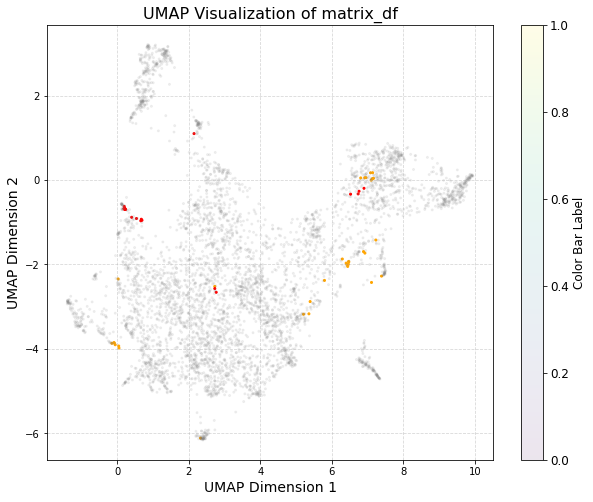

In [475]:
# Create a larger figure with improved styling
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

# Create a scatter plot with a color bar
#scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], s=4, c=c, cmap=cmap)  # Adjust 's' for point size

# Filter data to exclude grey points
c = np.array(c)
non_grey_indices = np.where(c != 'grey')
grey_indices = np.where(c == 'grey')

# Create the scatter plot
scatter = plt.scatter(umap_result[non_grey_indices, 0], umap_result[non_grey_indices, 1], s=4, c=c[non_grey_indices], cmap=cmap)

scatter = plt.scatter(umap_result[grey_indices, 0], umap_result[grey_indices, 1], s=4, c=c[grey_indices], cmap=cmap, zorder=1,
                     alpha=0.1)


plt.title('UMAP Visualization of matrix_df', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)

# Customize the color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Color Bar Label', fontsize=12)  # Replace with an appropriate label
cbar.ax.tick_params(labelsize=12)  # Adjust color bar label size

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()


In [390]:
umap_result.shape

(4972, 2)

# Old

In [17]:


def run_multiprocess(func, tasks, n_cores, tasks_per_core=1):
        
    stdout_queue = multiprocessing.Queue()
    pool = multiprocessing.Pool(processes=n_cores, initargs=[stdout_queue], maxtasksperchild=tasks_per_core)
    for i, data in enumerate(pool.starmap(func, tasks), 1):
        yield data
    pool.close()
    pool.join()



In [29]:

pdb_dir = '/home/users/sdunin/calc/HAMPpred/data/input/af2_full'
usexecutable = '/home/users/sdunin/apps/USalign/USalign'

def align(i,j,pdb1, pdb2):
    usexecutable = '/home/users/sdunin/apps/USalign/MMalign'
    
    align_res = subprocess.run(
        [usexecutable, pdb1, pdb2, '-mm', '1', '-ter', '0', '-outfmt', '2'],
        capture_output=True, text=True
    )
    res = align_res.stdout.split('\n')[1].split('\t')
    return [i,j]+res

num_cpus = 15
pool = Pool(processes=num_cpus)

#max_index = len(data_df.index)
max_index = 100

print('generating jobs...')

jobs = []

for i in range(max_index):
    idx1 = data_df.index[i]
    row1 = data_df.loc[idx1]
    pdb1 = os.path.join(pdb_dir, row1.pdb_file)
    
    for j in range(i + 1, max_index):
        idx2 = data_df.index[j]
        row2 = data_df.loc[idx2]
        pdb2 = os.path.join(pdb_dir, row2.pdb_file)

        jobs.append((idx1, idx2, pdb1, pdb2))

jobs_count = len(jobs)
print(f'running {jobs_count} jobs on {num_cpus} cpus...')
        
results = []      
with tqdm(total=jobs_count) as pbar:       
    for res in run_multiprocess(align, jobs, 10):
        results.append(res)
        assert len(res)==13
        pbar.update(10)

generating jobs...
running 4950 jobs on 15 cpus...


49500it [00:38, 1282.17it/s]                                                                                                                                  


In [ ]:
head = ['i', 'j', 'PDBchain1', 'PDBchain2', 'TM1', 'TM2', 'RMSD', 'ID1', 'ID2', 'IDali', 'L1', 'L2', 'Lali']
res_df = pd.DataFrame(results, columns=head)
res_df.to_pickle('./tmp/AF2_clust.p')

In [25]:
len(data_df)

150